In [5]:
label_names = ['good weld', 'burn through', 'contamination', 'lack of fusion', 'misalignment', 'lack of penetration']

In [6]:
import torch
import torch.nn as nn
from PIL import Image
import os
import json
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image
import cv2
import torchvision.models as models
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from tqdm import tqdm
import cv2
import pickle

In [7]:
f = open('al5083/train/train.json')
data = json.load(f)

In [8]:
test_dir = 'al5083/test'
train_dir = 'al5083/train'

In [9]:
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [10]:
class WeldDataset(Dataset):
  def __init__(self, metadata,root, transform = None, processor = None):
    with open(os.path.join(root, metadata), 'r') as file:
            self.metadata = json.load(file)
    self.transform = transform
    self.root = root
    self.processor = processor

  def __len__(self):
    return len(self.metadata)

  def __getitem__(self, idx):
    image, label = list(self.metadata.keys())[idx], list(self.metadata.values())[idx]
    image = Image.open(os.path.join(self.root,image)).convert('RGB')

    if self.transform:
      image = self.transform(image)

    return image, label

In [11]:
train_dataset = WeldDataset(metadata = 'train.json', root = train_dir, transform = transform)

In [12]:
test_dataset = WeldDataset(metadata = 'test.json', root = test_dir, transform = transform)

In [13]:
num_classes = 6
learning_rate = 1e-3
batch_size = 8
num_epochs = 10

In [14]:
cpu_count = os.cpu_count()-1

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [16]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
device

device(type='cuda')

In [19]:
torch.cuda.empty_cache()

In [20]:
model = models.resnet50(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
model = model.to(device)

C:\Users\sumit.LAPTOP-RVM6FB33\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sumit.LAPTOP-RVM6FB33\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
checkpoint = torch.load('model_parms1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [22]:
def accuracy(network, dataloader):
    network.eval()

    total_correct = 0
    total_instances = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
          images, labels = images.to(device), labels.to(device)
        
          classifications = torch.argmax(network(images), dim=1)
        
          correct_predictions = sum(classifications==labels).item()
        
          total_correct+=correct_predictions
          total_instances+=len(images)
    network.train()
    return round(total_correct/total_instances, 3)

Actual Label  burn through
Predicted Label  contamination


C:\Users\sumit.LAPTOP-RVM6FB33\AppData\Local\Temp\ipykernel_16876\3716408914.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft = F.softmax(logits)


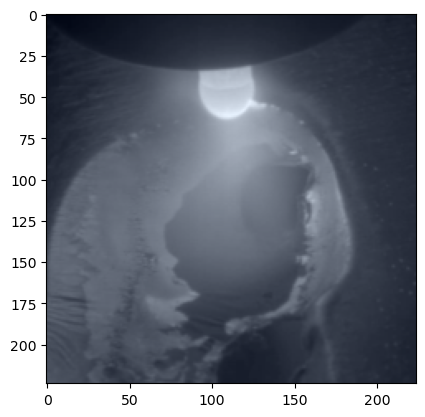

In [24]:
model.eval()
data, label = test_dataset[random.randint(0, len(test_dataset)-1)]
data = (data-data.min())/(data.max()-data.min())
logits = model(data.to(device).unsqueeze(0))
plt.figure()
plt.imshow(data.numpy().transpose(1,2,0))
plt.plot()
print('Actual Label ', label_names[label])
soft = F.softmax(logits)
label_pred = torch.argmax(soft).item()
print('Predicted Label ', label_names[label_pred])


In [25]:
# model

In [26]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image

In [27]:
test_dataset[0][0].unsqueeze(0).to(device).shape

torch.Size([1, 3, 224, 224])

In [28]:
def show_cam_on_image_mod(img, mask, use_rgb=False, colormap=cv2.COLORMAP_JET, image_weight=0.7):
    import cv2
    
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    heatmap = np.float32(heatmap) / 255
    
    if np.max(img) > 1:
        raise Exception("The input image should np.float32 in the range [0, 1]")
    
    if image_weight < 0 or image_weight > 1:
        raise Exception("image_weight should be in the range [0, 1]. Got: {image_weight}")
    
    cam = heatmap + image_weight * np.float32(img)
    cam = cam / np.max(cam)
    
    return np.uint8(255 * cam)

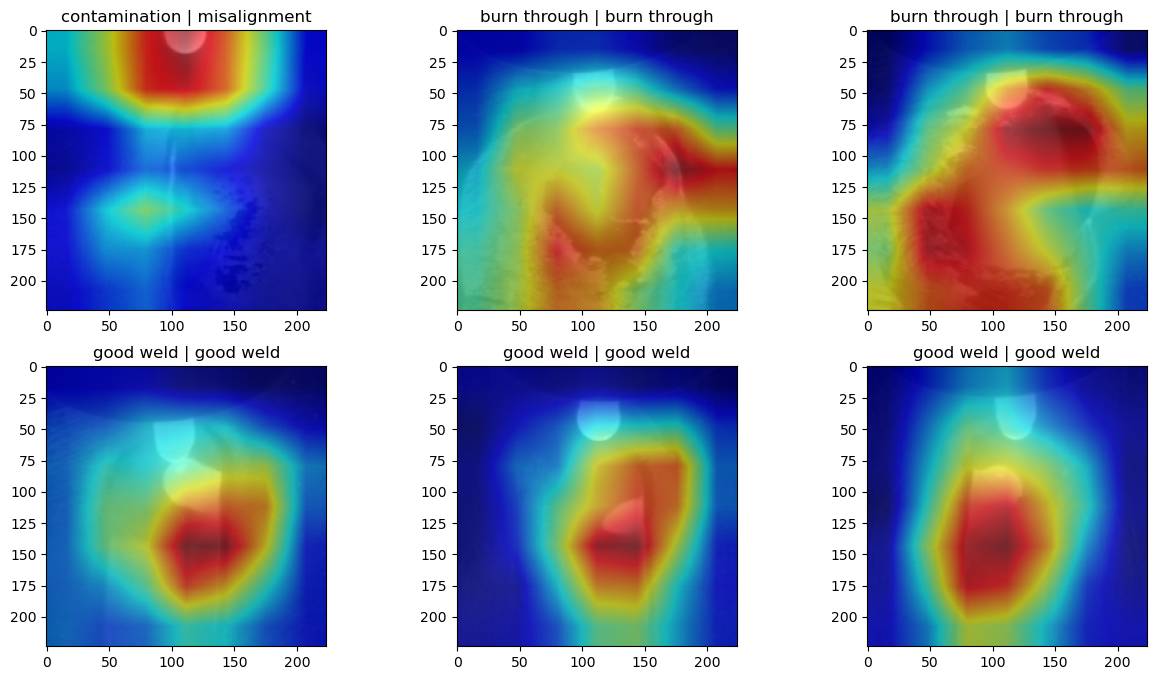

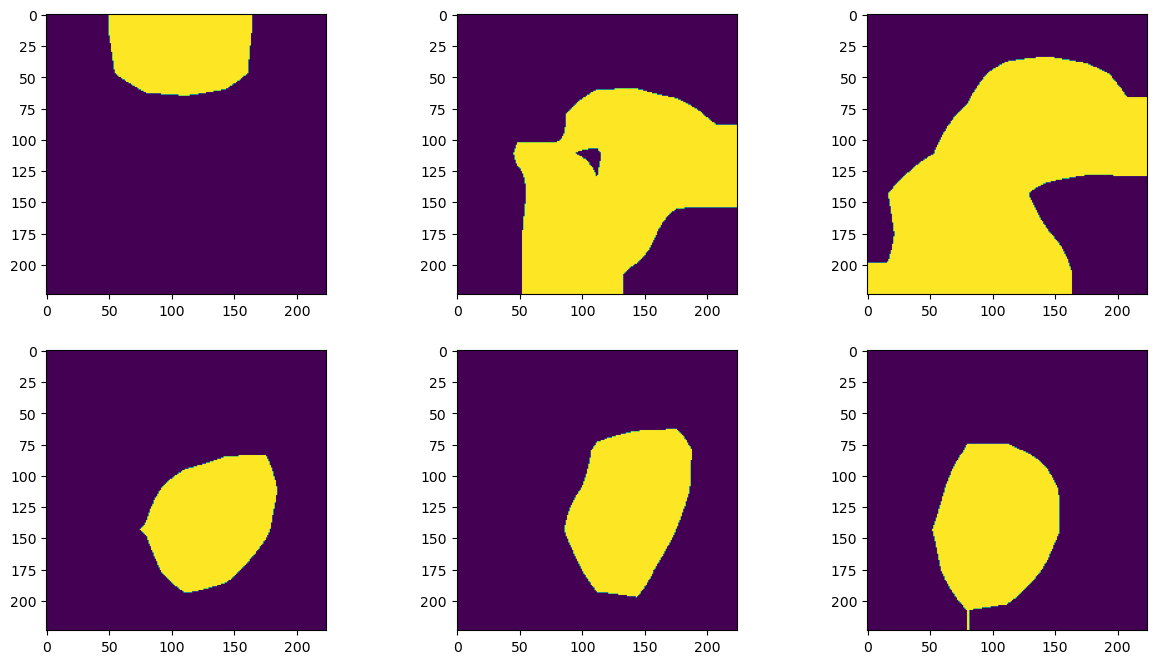

In [29]:
model.eval()
target_layer = model.layer4[-1]
cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig2, axes2 = plt.subplots(2,3, figsize=(15,8))
axes2 = axes2.flatten();
k = 0;
for ax in axes.flat:
    image, label = test_dataset[random.randint(0, len(test_dataset) - 1)]
    input_image = image.unsqueeze(0).to(device)
    target_category = None
    output = model(input_image)
    target_category = torch.argmax(output).item()
    targets = [ClassifierOutputTarget(target_category)]
    grayscale_cam = cam(input_tensor=input_image, targets=targets)

    input_image_np = input_image.squeeze().cpu().numpy().transpose(1, 2, 0)
    input_image_np = (input_image_np - input_image_np.min()) / (input_image_np.max() - input_image_np.min())
    input_image_np = input_image_np.astype(np.float32)
    
    visualization = show_cam_on_image_mod(input_image_np, grayscale_cam.squeeze(), use_rgb=True)
    ax.imshow(visualization)
    ax.set_title(f'{label_names[label]} | {label_names[target_category]}')

    ccc = grayscale_cam*255
    ccc = ccc.astype('int')
    ccc = ccc.squeeze()
    binary_mask = np.where(ccc > 150, 1, 0)
    axes2[k].imshow(binary_mask)
    k+= 1
    

plt.show()

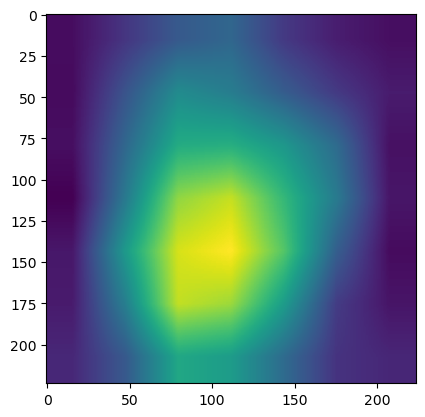

In [30]:
ccc = grayscale_cam*255
ccc = ccc.astype('int')
ccc = ccc.squeeze()
plt.imshow(ccc)


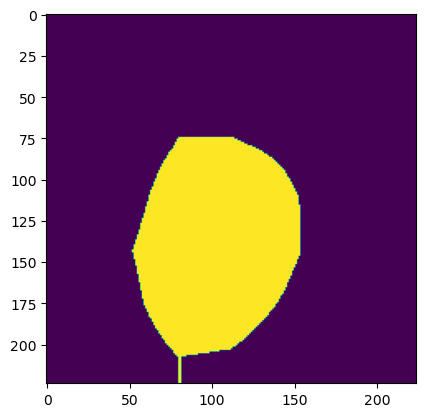

In [31]:
binary_mask = np.where(ccc > 150, 1, 0)
plt.imshow(binary_mask)

In [32]:
# image.shape

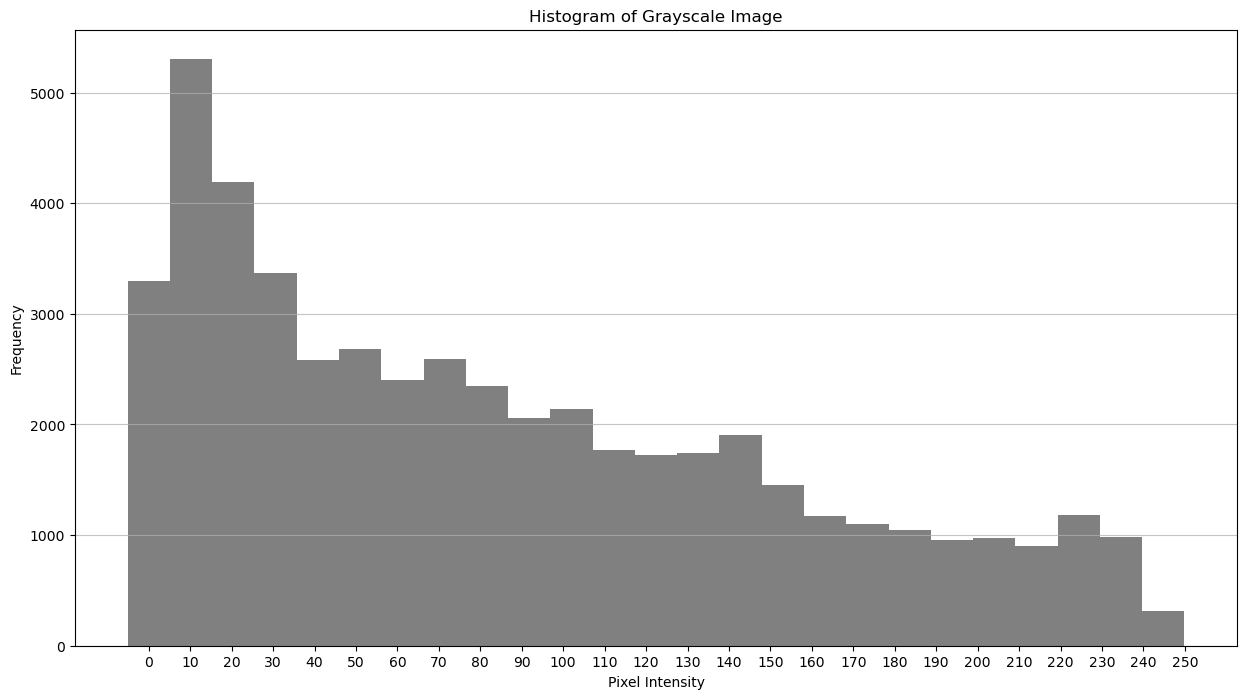

In [33]:
hist, bins = np.histogram(ccc, bins=25, range=[0, 255])

# Plot histogram
plt.figure(figsize=(15, 8))
plt.bar(bins[:-1], hist, width=np.diff(bins), color='gray')
plt.title('Histogram of Grayscale Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 256, step=10))  
plt.grid(axis='y', alpha=0.75)  
plt.show()

In [34]:
hist

array([3294, 5303, 4191, 3371, 2586, 2680, 2399, 2596, 2346, 2058, 2137,
       1770, 1727, 1739, 1901, 1457, 1177, 1099, 1043,  958,  973,  904,
       1178,  979,  310], dtype=int64)

In [35]:
# CHECKPOINT_PATH='sam_vit_h_4b8939.pth'

In [36]:
# import torch
# DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# MODEL_TYPE = "vit_h"

In [37]:
# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

# mask_generator = SamAutomaticMaskGenerator(sam)

In [38]:



# # Give the path of your image
# IMAGE_PATH= 'al5083/train/170904-112347-Al 2mm/frame_00054.png'
# # Read the image from the path
# image= cv2.imread(IMAGE_PATH)
# # Convert to RGB format
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# # Generate segmentation mask
# output_mask = mask_generator.generate(image_rgb)


In [39]:
# len(output_mask)

In [40]:
# n = len(output_mask)
# r = 2
# c = n//2

# if n%2 != 0:
#     c = c + 1

In [41]:
# fig, axes = plt.subplots(r, c, figsize=(15, 8))
# axes = axes.flatten()
# for idx, mask in enumerate(output_mask):
#     axes[idx].imshow(mask['segmentation'].astype(int), cmap='gray')
#     axes[idx].axis('off')
# for idx in range(len(output_mask), len(axes)):
#     axes[idx].axis('off')

# plt.tight_layout()
# plt.show()

In [42]:
# import os
# from multiprocessing import Pool, cpu_count
# def generate_mask(image_path):
#     # Read the image from the path
#     image = cv2.imread(image_path)
#     # Convert to RGB format
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     # Generate segmentation mask
#     output_mask = mask_generator.generate(image_rgb)
#     return output_mask

# def process_images(image_paths):
#     with Pool(cpu_count()) as pool:
#         masks = pool.map(generate_mask, image_paths)
#     return masks


# image_dir = 'al5083/train/170904-112347-Al 2mm'
#     # Get list of image paths
# image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.png')]

# # Process images
# masks = process_images(image_paths)


In [43]:
# # Save or handle masks as needed
# for image_path, mask in zip(image_paths, masks):
#     output_path = image_path.replace('.png', '_mask.npy')  # Save mask with a different extension or name
#     np.save(output_path, mask)

In [46]:
# from torch.cuda.amp import GradScaler, autocast
# from torch.utils.checkpoint import checkpoint

In [50]:
from tqdm.auto import tqdm
images = []
labels = []
label_count = [0]*6

import json
with open(f'al5083/train/train.json', 'r') as f:
    data = json.load(f)

for img,lbl in tqdm(data.items()):
    
    if(label_count[lbl] > 50):
        continue
    label_count[lbl] += 1
    images.append(img)
    labels.append(lbl)

  0%|          | 0/26666 [00:00<?, ?it/s]

In [51]:
import pickle
with open('maks_all.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

In [52]:
def gen_cam(image,label):
    input_image = image.unsqueeze(0).to(device)
    target_category = None
    output = model(input_image)
    target_category = torch.argmax(output).item()
    targets = [ClassifierOutputTarget(target_category)]
    grayscale_cam = cam(input_tensor=input_image, targets=targets)

    c = grayscale_cam*255
    c = c.astype('int')
    c = c.squeeze()
    binary_mask = np.where(c > 170, 1, 0)
    return binary_mask, target_category, grayscale_cam
    

In [53]:
def iou(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    
    iou = intersection / union
    
    return iou

In [54]:
nonormal_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])

In [55]:
def mask_to_xywh(mask):
    nz_pixels = np.nonzero(mask)
    
    if len(nz_pixels[0]) == 0:
        return (0, 0, 0, 0)
    
    x = np.min(nz_pixels[1])
    y = np.min(nz_pixels[0])
    w = np.max(nz_pixels[1]) - x
    h = np.max(nz_pixels[0]) - y
    
    return (x, y, w, h)

In [56]:
mask_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
    ])

In [57]:
def sammed(t):
    t = Image.fromarray(t)
    t = mask_transform(t)
    t = np.array(t)
    return t

In [58]:
def midofmask(box):
    x = int(box[0] + box[2]/2)
    y = int(box[1] + box[3]/2)
    return x,y

In [60]:
from tqdm.auto import tqdm

In [61]:
def mask_area(mask):
    return np.sum(mask)

from PIL import ImageDraw
def draw_bbox(image, box, outline="red", width=2):
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    x, y, w, h = box
    draw.rectangle([x, y, x + w, y + h], outline=outline, width=width)

In [62]:
def mod_box(box, pad=1):
    x,y,w,h = box
    scale_x = 224/800
    scale_y = 224/974

    x = int(x*scale_x) - pad
    y = int(scale_y*y) - pad
    w = int(scale_x*w) + pad
    h = int(scale_y*h) + pad

    return x,y,w,h

In [63]:
sam_cam_outs = []
for i, (img,lbl) in tqdm(enumerate(zip(images, labels))):
    # if (i != 4):
    #     continue
    image = Image.open(f'{train_dir}/{img}').convert('RGB')
    t = nonormal_transform(image)
    image = transform(image)
    bmask, pred, cam_full = gen_cam(image,lbl)
    # print(f'pred: {pred} actual: {lbl}')
    # sam_masks = loaded_data[i]
    sam_masks = [mask for mask in loaded_data[i] if 10000 < mask_area(mask[0]) < 250000]
    ious = np.array([iou(sammed(mask[0]), bmask) for mask in sam_masks])
    best_mask_id = np.argmax(ious)
    # sam_cam_outs.append((t,sam_masks[best_mask_id], bmask, lbl, pred))
    sam_cam_outs.append({
        'image': t,
        'sam_mask': sam_masks[best_mask_id],
        'cam_mask': bmask,
        'actual': lbl,
        'pred': pred,
        'cam_full': cam_full
    })

0it [00:00, ?it/s]

In [64]:
colors = ['green', 'red', 'orange','purple', 'pink', 'olive']

(224, 224, 3)


Text(0.5, 0.98, 'Actual: lack of penetration | Prediction: lack of penetration\n Bounding Box:[284, 411, 212, 562]\n Area cam:6433 Area sam:92971 mid_point of mask: (390, 692)')

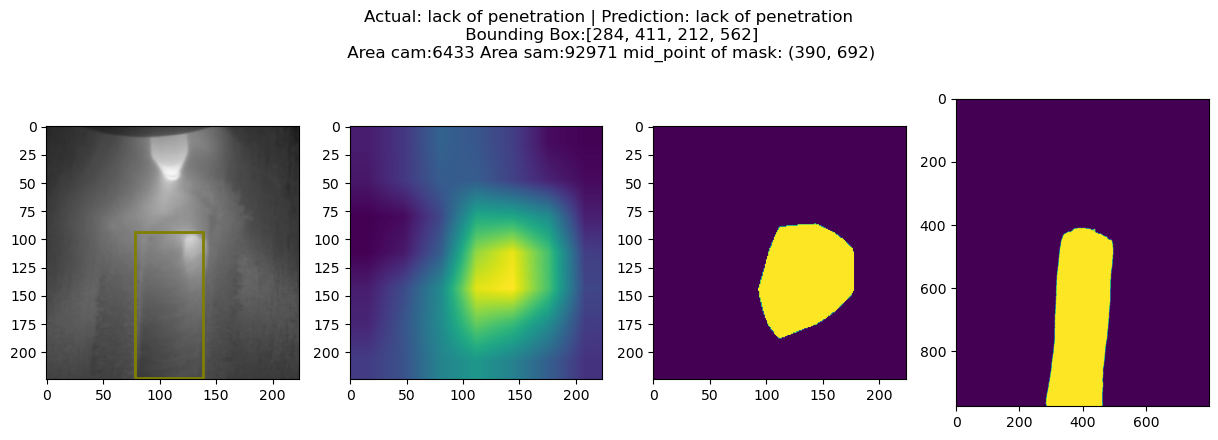

In [108]:
import matplotlib.patches as patches

idx = random.randint(0, len(sam_cam_outs)-1)
fig, axes = plt.subplots(1,4, figsize= (15,5))
axes = axes.flatten()

cam_mask = sam_cam_outs[idx]['cam_mask']
sam_mask = sam_cam_outs[idx]['sam_mask']

img = sam_cam_outs[idx]['image'].numpy().transpose(1,2,0)
# draw_bbox(img,sam_mask[1])

pred = sam_cam_outs[idx]['pred']


axes[0].imshow(img)

x, y, w, h = mod_box(sam_mask[1])
print(img.shape)

if (midofmask(sam_mask[1])[1] < 140):
    x,w,w,h = mask_to_xywh(cam_mask)


rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=colors[pred], facecolor='none')
axes[0].add_patch(rect)

axes[1].imshow(sam_cam_outs[idx]['cam_full'].squeeze())
axes[2].imshow(cam_mask)
axes[3].imshow(sam_mask[0].astype('int'))


fig.suptitle(f"Actual: {label_names[sam_cam_outs[idx]['actual']]} | Prediction: {label_names[sam_cam_outs[idx]['pred']]}\n Bounding Box:{sam_cam_outs[idx]['sam_mask'][1]}\n Area cam:{mask_area(cam_mask)} Area sam:{mask_area(sam_mask[0].astype('int'))} mid_point of mask: {midofmask(sam_mask[1])}")